# Loading the libraries

In [2]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00


In [3]:
import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import pandas as pd
import urllib.request
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Layer, Dropout
from tensorflow.keras.models import Model
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset

INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

2025-05-02 20:08:19.042484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746216499.240550      54 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746216499.302193      54 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 80000 #40000
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 30  # Number of epochs to train for.
MAX_LENGTH = 15

In [5]:
#Create the Checkpoint 
# Create a directory path for checkpoints
checkpoint_path = "./checkpoints/train"

url = 'https://raw.githubusercontent.com/SamirMoustafa/nmt-with-attention-for-ar-to-en/master/ara_.txt'
dataset = pd.read_csv(url, delimiter='\t', header=None, names=[TARGET_COLUMN ,INPUT_COLUMN])

In [6]:
def preprocess_text_nonbreaking(corpus, non_breaking_prefixes):
  corpus_cleaned = corpus
  # Add the string $$$ before the non breaking prefixes
  # To avoid remove dots from some words
  for prefix in non_breaking_prefixes:
    corpus_cleaned = corpus_cleaned.replace(prefix, prefix + '$$$')
  # Remove dots not at the end of a sentence
  corpus_cleaned = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_cleaned)
  # Remove the $$$ mark
  corpus_cleaned = re.sub(r"\.\$\$\$", '', corpus_cleaned)
  # Rmove multiple white spaces
  corpus_cleaned = re.sub(r"  +", " ", corpus_cleaned)

  return corpus_cleaned


## Loading the dataset

In [7]:
print(dataset)

                                                  target  \
0                                                    Hi.   
1                                                   Run!   
2                                                  Help!   
3                                                  Jump!   
4                                                  Stop!   
...                                                  ...   
10737  The mobile phone you have dialed is either swi...   
10738  A man touched down on the moon. A wall came do...   
10739  Make a good translation of the sentence that y...   
10740  Ladies and gentlemen, please stand for the nat...   
10741  There are mothers and fathers who will lie awa...   

                                                   input  
0                                                مرحبًا.  
1                                                  اركض!  
2                                                النجدة!  
3                                          

In [8]:
df = pd.DataFrame({
    INPUT_COLUMN:  dataset[INPUT_COLUMN],  # English sentences
    TARGET_COLUMN: dataset[TARGET_COLUMN]  # Arabic sentences
})

In [9]:
df = df.iloc[:NUM_SAMPLES]

In [10]:
input_data = df[INPUT_COLUMN].tolist()  
target_data = df[TARGET_COLUMN].tolist() 

In [11]:
# Print sample sentences
print('Number of sentences:', len(input_data))
print(input_data[:5])  # Sample English sentences
print(target_data[:5])  # Sample Arabic translations

Number of sentences: 10742
['مرحبًا.', 'اركض!', 'النجدة!', 'اقفز!', 'قف!']
['Hi.', 'Run!', 'Help!', 'Jump!', 'Stop!']


In [12]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

5

In [13]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove


In [14]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

In [15]:
# Check the tokenize function
print(encoder_inputs[:5], sos_token_input, eos_token_input)
print(decoder_outputs[:5], sos_token_output, eos_token_output)

[[12672  6118    21    31 12462 12673     0     0     0     0     0     0
      0     0     0]
 [12672 11409 12449 12673     0     0     0     0     0     0     0     0
      0     0     0]
 [12672  1207 12449 12673     0     0     0     0     0     0     0     0
      0     0     0]
 [12672 11287 12449 12673     0     0     0     0     0     0     0     0
      0     0     0]
 [12672  3381 12449 12673     0     0     0     0     0     0     0     0
      0     0     0]] [12672] [12673]
[[6010 1144 5800 6011    0    0    0    0    0    0    0    0    0    0
     0]
 [6010 5408 5787 6011    0    0    0    0    0    0    0    0    0    0
     0]
 [6010 5543 5787 6011    0    0    0    0    0    0    0    0    0    0
     0]
 [6010 5521 5787 6011    0    0    0    0    0    0    0    0    0    0
     0]
 [6010 3101 5787 6011    0    0    0    0    0    0    0    0    0    0
     0]] [6010] [6011]


In [16]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  12674
Size of Output Vocabulary:  6012


In [17]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

I0000 00:00:1746216550.787547      54 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746216550.788150      54 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Building a Transformer

## 🧠 Multi-Head Attention - Overview

This custom `MultiHeadAttention` layer implements the core idea behind the Transformer attention mechanism.

![Multi-Head Attention](https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png)


### 🔄 Step-by-step Flow:

1. **Input**:
   - Input tensors: `queries`, `keys`, `values` of shape `(batch_size, seq_len, d_model)`.
   - `mask` is optional and used to prevent attending to certain positions.

2. **Linear Projections**:
   - Each input (Q, K, V) is passed through a separate Dense layer to project them into the same dimension `d_model`.

3. **Split into Multiple Heads**:
   - The projected Q, K, V are reshaped and split into `n_heads`, each with a smaller dimensionality `d_head = d_model / n_heads`.
   - New shape: `(batch_size, n_heads, seq_len, d_head)`

4. **Scaled Dot-Product Attention** *(applied per head)*:
   - For each head:
      $$
      \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
      $$
   - `QK^T` computes similarity scores between each token.
   - Scores are scaled by `sqrt(d_k)` to avoid large gradients.
   - Softmax turns them into probabilities.
   - These weights are used to sum up the `V` values.

5. **Concatenate Heads**:
   - The output from all heads is transposed and reshaped back into a single tensor of shape `(batch_size, seq_len, d_model)`.

6. **Final Linear Layer**:
   - A Dense layer (`W₀`) combines all heads into a single output tensor.

---

### ✅ Purpose:
Multi-head attention allows the model to **attend to different representation subspaces** at different positions, helping it learn richer and more complex patterns than single-head attention.

In [18]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose "to get how much they are similler"
    # in case of self attention the Q is the same of K
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32) # -1 for the depth
    # Apply the scale factor to the dot product
    # because when the product is too big, he may give all attention to single word
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    # this is applied to skip any padding token
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    # softmax output is the weights "how much attention we must give to each word"
    # so now we multiply the weights with the values to get the actula attentions
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    # so this is the context vector, representation of each word but with cosidering the context
    return attention

In [19]:
class MultiHeadAttention(layers.Layer):
    # his parent is tf.keras.layers.Layer
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    # called automatically when the class called   
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # input shape is (batch_size, sequence_length, d_model)
        # batch size, is N *sentences* in one batch
        # seq length is N *tokens* on each *sentence*
        # d model is N *dimensions* that each *token* represented by
        # assert is a keyword to check if the condition is true
        # we want each head to have the same dimensions
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        # units means number of units * we set it equals dimensions *
        # we want the Q,K,V to be converted into desne so that the model learn 
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        # this used after mixing all heads 
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1, # seq length but here we let tensorflow calculate it by itself
                 self.n_heads,
                 self.d_head) # dimensions for each head
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        # before transpose: (batch_size, sequence_length, n_heads, d_head) 
        # after transpose: (batch_size, n_heads, sequence_length, d_head) 
        # we can say head or projection "they are the same"
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, n_heads, sequence_length, d_head) 
    
    # this called when you call the class
    def call(self, queries, keys, values, mask):
        # Get the batch size "first diemsion of the queries"
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        # we split the K, Q, V to heads , and before we intialized the lin
        # now we want these dense to take the actual Q K V 
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        # calculate the attention for each head
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        # we reorder the attention as it was (batch, n_heads, seq_len, d_head)
        # after transpose it becomes (batch, seq_len, n_heads, d_head)
        # so now we can concat them
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        # we go back to the older shape but with diff values after each head learned
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs



### Positional Encoding Explanation
![Positional Encoding Overview](https://www.researchgate.net/publication/356679235/figure/fig6/AS:1098153185021953@1638831530545/An-over-view-of-the-working-of-positional-encoding-in-Transformer-Neural-Networks_W640.jpg)

We use the periodic functions `sin` and `cos` to represent the positional encoding vector. For each position, we use the formula:

$$
\text{angle} = \frac{\text{pos}}{10000^{\frac{2i}{d_\text{model}}}}
$$

Where:

* **pos** is the position of the word in the sentence (e.g., 0 for the first word).
* **i** is the dimension index (e.g., 0, 1, 2, ..., `d_model`).
* **d\_model** is the number of dimensions each word is represented by.

For even dimensions (i.e., 0, 2, 4...), we apply `sin`, and for odd dimensions (i.e., 1, 3, 5...), we apply `cos`.

![Positional Encoding Overview](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F58a77f49-ed6d-4614-9c64-505455bd0c83_2043x1300.png)

This method helps us create a unique encoding for each position in the sequence. As the position increases, the wave becomes wider (lower frequency). Changing the position results in a completely different encoding.

### Why `sin` and `cos`?

* We use `sin` for even positions and `cos` for odd positions to ensure **no repetition** of the positional encoding.
* We don't use `sigmoid` because it would produce similar encodings for different positions.
* The number `10000` is used to ensure that the wave doesn't repeat too quickly, even for long sequences (e.g., 1,000,000 words).
This way, each word in the sequence gets a unique encoding based on its position, helping the model understand the order of words.



In [ ]:
class PositionalEncoding(layers.Layer):
# we need positional encoding as the model itself dosen't cosider the position of each word

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    # a function calculates the theta to put the cos and sin to perform positional encoding
    # pos : is the position of the word in the sentence "0 for 1st word"
    # i , is the dimension number 
    # d_model is N dimensions that each word represented by
    # i // 2 because each 2 dim shares the same freq, one for sin and the other for cosine
    # (2*(i//2)) / np.float32(d_model) claculates the frequancy so that each dim has diff wave
    # 1 / 10000  this scales down the output so that the wave is small and matched
    # pos * angles , each word has different number according to its position on the sentence
    def get_angles(self, pos, i, d_model): 
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape (batch_size, "seq_length", "d_model")
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        # we make a matrix contains 0-> seq lenght-1 " the positions"\
        # and another one contains the numbers from 0 -> d_model "number of dim represnts each word"
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        # now we add the positional encoding to the inpusts 
        # so now the encoded inputs contains the word represntation and the position
        return inputs + tf.cast(pos_encoding, tf.float32)

# 🔤 Transformer Encoder Overview

The **Encoder** is a main part of the Transformer model.

It takes a sentence and turns each word into a rich vector that knows the context of the whole sentence.

---

## 📦 The Encoder Structure

The Encoder is made of:

1. **Embedding Layer**  
   Converts word IDs to vectors of size `d_model`.

2. **Positional Encoding**  
   Adds information about the position of each word in the sentence.

3. **Dropout Layer**  
   Used to prevent overfitting during training.

4. **Stack of Encoder Layers**  
   Repeated `n_layers` times.


---

## 🔁 Each Encoder Layer has:

1. **Multi-Head Self Attention**  
   - Looks at other words in the sentence to understand context.  
   - Self-attention means Query = Key = Value = input.

2. **Add & Normalize**  
   - Adds the attention output to the input (residual connection).  
   - Applies Layer Normalization.

3. **Feed Forward Neural Network (FFN)**  
   - Two dense layers:
     - One with ReLU activation.
     - One linear (no activation).
   - Helps transform the features.

4. **Add & Normalize again**  
   - Adds FFN output to the attention output (residual connection).  
   - Applies Layer Normalization.

5. **Dropout Layers**  
   - Applied after attention and FFN to prevent overfitting.

## 🖼️ Visual Example

<img src="http://researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg" height="900" style="display: block; margin: 0 auto;"/>




In [ ]:
class EncoderLayer(layers.Layer):
    
    # FF stands for feed forward
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        # take the batch size
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # attention for the same input as we start K = Q = V "self attention"
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [22]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        # because that the values comes from the embedding may be soo small or so big
        # so the scaling helps for better gradient
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training=training)

        return outputs

# 🔄 Transformer Decoder Overview

The Decoder Layer processes target inputs and incorporates encoder outputs to generate context-aware predictions. It contains 3 main blocks:

---

![Transformer Attention Model](https://pylessons.com/media/Tutorials/transformers/transformer-attention/model-min.png)


### 1. 🔷 Causal Self-Attention
- Allows attention to previous tokens only (prevents seeing future).
- Uses multi-head attention + dropout + layer norm.
  


### 2. 🔷 Encoder-Decoder Attention
- Lets decoder focus on encoder outputs (source sentence).
- Uses multi-head attention with encoder output as keys/values.
- Followed by dropout + layer norm.



### 3. 🔷 Feed Forward Network (FFN)
- Two dense layers with ReLU in between.
- Applies position-wise transformation.
- Includes dropout + layer norm.


### 🧩 Residual & Normalization
- Each block uses a residual connection followed by layer normalization to stabilize and speed up training.



### 📥 Inputs
- `inputs`: From previous decoder layer or embedding.
- `enc_outputs`: Encoder outputs.
- `mask_1`: Causal mask for self-attention.
- `mask_2`: Padding mask for encoder-decoder attention.
- `training`: Controls dropout behavior.


### 📤 Output
- Processed sequence passed to the next decoder layer or final output layer.

In [23]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)

    # mask 1 is the lookahead mask or causual mask, prevernt the decoder from considering non generated words
    # mask 2 prevent the decoder from considering the padding 
    # training is a boolean equals true on training and false on evaluation "controls the dropout"     
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training=training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training=training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training=training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [24]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers, # how many decoder layer we will use
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size, # number of vocabs in the generated language
                 d_model, # dimnesions for each word after embedding
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    # enc_outputs is the outputs of the encoder, we will use it in the 2nd block
    # mask 1 is the lookahead mask or causual mask, prevernt the decoder from considering non generated words
    # mask 2 prevent the decoder from considering the padding 
    # training is a boolean equals true on training and false on evaluation "controls the dropout" 
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model 
        # because that the values comes from the embedding may be soo small or so big
        # so the scaling helps for better gradient
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training=training)

        return outputs

### Explanation of Look-Ahead Mask

The **look-ahead mask** is used in the Transformer model to prevent the **decoder** from looking at future tokens when making predictions. This ensures that the model only uses past and current tokens.

#### Steps:

1. **Get the sequence length:**
   This gives the number of tokens in the sequence.

2. **Create a matrix of ones:**
   This creates a square matrix filled with `1`s.

3. **Make it lower triangular (band part):**
   This converts the matrix into a lower triangular form where only the elements below and including the diagonal are `1`.

   Example of a 5x5 matrix:

   ```
   [[1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1]]
   ```

4. **Invert the values:**
   This inverts the values, turning `1`s into `0`s and vice versa. After inversion, the look-ahead mask would look like:

   ```
   [[0, 1, 1, 1, 1],
    [0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]]
   ```

#### Why is it used?

The look-ahead mask ensures the **decoder** only attends to the current and past tokens, not future ones. This prevents "cheating" when predicting the next token.

In [25]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc, 
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    # Seq is the input data into the decoder or encoder
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # this returns tensor has the same shape of the seq but 
        # represents each real word with 0 and each padding with 1 "when the value is 0 then represnet it with 1"
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        # seq[1] means the sequance length 
        seq_len = tf.shape(seq)[1]
        # tf.ones((seq_len, seq_len)) creates a square matrix contians only 1z, with shape (seq_len, seq_len)
        # band part is a function generates a lower triangle from the matrix
        # -1 means allowing all the elements under the diagonal 
        # 0 means the matrix contains 0 above the diagonal
        # 1- means inversing the numbers "0 becomes 1 and vice versa"
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        # this mask means that each 0 is a future word you must ignore 
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention "first block"
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention "second block"
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training=training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training=training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)
        
        return outputs

In [26]:
def loss_function(target, pred):
    # logical not , outputs true when the value is zero "padding", and vise versa
    # so now we know where is the padding "true"
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    # now convert the mask into the same type of the loss instead of true and false
    mask = tf.cast(mask, dtype=loss_.dtype)
    # apply the mask on the loss so if its padding so the loss is 0
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float to avoid type issues.
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [27]:
from tqdm import tqdm  # Import tqdm for progress bar

def main_train(dataset, transformer, n_epochs, print_every=50):
    ''' Train the transformer model for n_epochs using the data generator dataset'''
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}")
        start = time.time()

        # Reset the loss and accuracy calculations
        train_loss.reset_state()
        train_accuracy.reset_state()

        # Create a tqdm progress bar for the batch loop
        progress_bar = tqdm(enumerate(dataset), total=len(dataset), desc=f"Epoch {epoch+1}", position=0, leave=True)

        for batch, (enc_inputs, targets) in progress_bar:
            # Set the decoder inputs
            dec_inputs = targets[:, :-1]
            # Set the target outputs, right-shifted
            dec_outputs_real = targets[:, 1:]

            with tf.GradientTape() as tape:
                # Call the transformer and get the predicted output
                predictions = transformer(enc_inputs, dec_inputs, training=True)
                # Calculate the loss
                loss = loss_function(dec_outputs_real, predictions)

            # Update the weights and optimizer
            gradients = tape.gradient(loss, transformer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

            # Save and store the metrics
            train_loss(loss)
            train_accuracy(dec_outputs_real, predictions)

            # Update tqdm progress bar description with live loss & accuracy
            progress_bar.set_postfix(loss=train_loss.result().numpy(), accuracy=train_accuracy.result().numpy())

            # Print every `print_every` batches
            if batch % print_every == 0:
                losses.append(train_loss.result().numpy())
                accuracies.append(train_accuracy.result().numpy())

        # Save checkpoint after each epoch
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for epoch {epoch+1} in {ckpt_save_path}")
        print(f"Time for 1 epoch: {time.time() - start:.2f} secs\n")

    return losses, accuracies

In [28]:
# Set hyperparamters for the model
D_MODEL = 512 # 512
N_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
N_HEADS = 8 # 8
DROPOUT_RATE = 0.1 # 0.1


In [29]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

In [30]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [31]:
# Train the model
losses, accuracies = main_train(dataset, transformer, 70, 100)

Starting epoch 1


Epoch 1: 100%|██████████| 167/167 [03:35<00:00,  1.29s/it, accuracy=0.0628, loss=4.44] 


Saving checkpoint for epoch 1 in ./checkpoints/train/ckpt-1
Time for 1 epoch: 216.93 secs

Starting epoch 2


Epoch 2: 100%|██████████| 167/167 [03:27<00:00,  1.24s/it, accuracy=0.16, loss=3.22] 


Saving checkpoint for epoch 2 in ./checkpoints/train/ckpt-2
Time for 1 epoch: 208.23 secs

Starting epoch 3


Epoch 3: 100%|██████████| 167/167 [03:28<00:00,  1.25s/it, accuracy=0.206, loss=2.67]


Saving checkpoint for epoch 3 in ./checkpoints/train/ckpt-3
Time for 1 epoch: 210.09 secs

Starting epoch 4


Epoch 4: 100%|██████████| 167/167 [04:15<00:00,  1.53s/it, accuracy=0.231, loss=2.36]


Saving checkpoint for epoch 4 in ./checkpoints/train/ckpt-4
Time for 1 epoch: 257.09 secs

Starting epoch 5


Epoch 5: 100%|██████████| 167/167 [03:24<00:00,  1.22s/it, accuracy=0.256, loss=2.11]


Saving checkpoint for epoch 5 in ./checkpoints/train/ckpt-5
Time for 1 epoch: 205.39 secs

Starting epoch 6


Epoch 6: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.279, loss=1.89]


Saving checkpoint for epoch 6 in ./checkpoints/train/ckpt-6
Time for 1 epoch: 204.92 secs

Starting epoch 7


Epoch 7: 100%|██████████| 167/167 [03:24<00:00,  1.22s/it, accuracy=0.301, loss=1.7] 


Saving checkpoint for epoch 7 in ./checkpoints/train/ckpt-7
Time for 1 epoch: 205.49 secs

Starting epoch 8


Epoch 8: 100%|██████████| 167/167 [03:22<00:00,  1.22s/it, accuracy=0.322, loss=1.52]


Saving checkpoint for epoch 8 in ./checkpoints/train/ckpt-8
Time for 1 epoch: 204.09 secs

Starting epoch 9


Epoch 9: 100%|██████████| 167/167 [03:24<00:00,  1.22s/it, accuracy=0.345, loss=1.35]


Saving checkpoint for epoch 9 in ./checkpoints/train/ckpt-9
Time for 1 epoch: 205.38 secs

Starting epoch 10


Epoch 10: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.367, loss=1.19]


Saving checkpoint for epoch 10 in ./checkpoints/train/ckpt-10
Time for 1 epoch: 204.96 secs

Starting epoch 11


Epoch 11: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.388, loss=1.04]


Saving checkpoint for epoch 11 in ./checkpoints/train/ckpt-11
Time for 1 epoch: 205.07 secs

Starting epoch 12


Epoch 12: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.408, loss=0.906]


Saving checkpoint for epoch 12 in ./checkpoints/train/ckpt-12
Time for 1 epoch: 204.70 secs

Starting epoch 13


Epoch 13: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.43, loss=0.779] 


Saving checkpoint for epoch 13 in ./checkpoints/train/ckpt-13
Time for 1 epoch: 204.50 secs

Starting epoch 14


Epoch 14: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.448, loss=0.668]


Saving checkpoint for epoch 14 in ./checkpoints/train/ckpt-14
Time for 1 epoch: 204.38 secs

Starting epoch 15


Epoch 15: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.463, loss=0.574]


Saving checkpoint for epoch 15 in ./checkpoints/train/ckpt-15
Time for 1 epoch: 204.10 secs

Starting epoch 16


Epoch 16: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.478, loss=0.489]


Saving checkpoint for epoch 16 in ./checkpoints/train/ckpt-16
Time for 1 epoch: 203.87 secs

Starting epoch 17


Epoch 17: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.489, loss=0.426]


Saving checkpoint for epoch 17 in ./checkpoints/train/ckpt-17
Time for 1 epoch: 203.79 secs

Starting epoch 18


Epoch 18: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.499, loss=0.374]


Saving checkpoint for epoch 18 in ./checkpoints/train/ckpt-18
Time for 1 epoch: 204.04 secs

Starting epoch 19


Epoch 19: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.505, loss=0.339]


Saving checkpoint for epoch 19 in ./checkpoints/train/ckpt-19
Time for 1 epoch: 203.13 secs

Starting epoch 20


Epoch 20: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.512, loss=0.306]


Saving checkpoint for epoch 20 in ./checkpoints/train/ckpt-20
Time for 1 epoch: 203.54 secs

Starting epoch 21


Epoch 21: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.517, loss=0.283]


Saving checkpoint for epoch 21 in ./checkpoints/train/ckpt-21
Time for 1 epoch: 203.58 secs

Starting epoch 22


Epoch 22: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.517, loss=0.276]


Saving checkpoint for epoch 22 in ./checkpoints/train/ckpt-22
Time for 1 epoch: 202.80 secs

Starting epoch 23


Epoch 23: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.519, loss=0.268]


Saving checkpoint for epoch 23 in ./checkpoints/train/ckpt-23
Time for 1 epoch: 203.28 secs

Starting epoch 24


Epoch 24: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.518, loss=0.266]


Saving checkpoint for epoch 24 in ./checkpoints/train/ckpt-24
Time for 1 epoch: 203.44 secs

Starting epoch 25


Epoch 25: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.52, loss=0.257] 


Saving checkpoint for epoch 25 in ./checkpoints/train/ckpt-25
Time for 1 epoch: 203.14 secs

Starting epoch 26


Epoch 26: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.526, loss=0.234]


Saving checkpoint for epoch 26 in ./checkpoints/train/ckpt-26
Time for 1 epoch: 203.50 secs

Starting epoch 27


Epoch 27: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.53, loss=0.219] 


Saving checkpoint for epoch 27 in ./checkpoints/train/ckpt-27
Time for 1 epoch: 202.97 secs

Starting epoch 28


Epoch 28: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.535, loss=0.197]


Saving checkpoint for epoch 28 in ./checkpoints/train/ckpt-28
Time for 1 epoch: 203.85 secs

Starting epoch 29


Epoch 29: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.54, loss=0.18]  


Saving checkpoint for epoch 29 in ./checkpoints/train/ckpt-29
Time for 1 epoch: 203.18 secs

Starting epoch 30


Epoch 30: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.543, loss=0.17] 


Saving checkpoint for epoch 30 in ./checkpoints/train/ckpt-30
Time for 1 epoch: 203.76 secs

Starting epoch 31


Epoch 31: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.546, loss=0.156]


Saving checkpoint for epoch 31 in ./checkpoints/train/ckpt-31
Time for 1 epoch: 203.03 secs

Starting epoch 32


Epoch 32: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.549, loss=0.147]


Saving checkpoint for epoch 32 in ./checkpoints/train/ckpt-32
Time for 1 epoch: 203.41 secs

Starting epoch 33


Epoch 33: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.552, loss=0.138]


Saving checkpoint for epoch 33 in ./checkpoints/train/ckpt-33
Time for 1 epoch: 203.59 secs

Starting epoch 34


Epoch 34: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.553, loss=0.13] 


Saving checkpoint for epoch 34 in ./checkpoints/train/ckpt-34
Time for 1 epoch: 203.14 secs

Starting epoch 35


Epoch 35: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.557, loss=0.122]


Saving checkpoint for epoch 35 in ./checkpoints/train/ckpt-35
Time for 1 epoch: 203.93 secs

Starting epoch 36


Epoch 36: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.559, loss=0.115]


Saving checkpoint for epoch 36 in ./checkpoints/train/ckpt-36
Time for 1 epoch: 203.53 secs

Starting epoch 37


Epoch 37: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.56, loss=0.109] 


Saving checkpoint for epoch 37 in ./checkpoints/train/ckpt-37
Time for 1 epoch: 204.12 secs

Starting epoch 38


Epoch 38: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.56, loss=0.108] 


Saving checkpoint for epoch 38 in ./checkpoints/train/ckpt-38
Time for 1 epoch: 203.83 secs

Starting epoch 39


Epoch 39: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.562, loss=0.0993]


Saving checkpoint for epoch 39 in ./checkpoints/train/ckpt-39
Time for 1 epoch: 203.76 secs

Starting epoch 40


Epoch 40: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.564, loss=0.094] 


Saving checkpoint for epoch 40 in ./checkpoints/train/ckpt-40
Time for 1 epoch: 204.55 secs

Starting epoch 41


Epoch 41: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.564, loss=0.0936]


Saving checkpoint for epoch 41 in ./checkpoints/train/ckpt-41
Time for 1 epoch: 204.26 secs

Starting epoch 42


Epoch 42: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.567, loss=0.0863]


Saving checkpoint for epoch 42 in ./checkpoints/train/ckpt-42
Time for 1 epoch: 203.43 secs

Starting epoch 43


Epoch 43: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.567, loss=0.083] 


Saving checkpoint for epoch 43 in ./checkpoints/train/ckpt-43
Time for 1 epoch: 204.14 secs

Starting epoch 44


Epoch 44: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.567, loss=0.0817]


Saving checkpoint for epoch 44 in ./checkpoints/train/ckpt-44
Time for 1 epoch: 203.06 secs

Starting epoch 45


Epoch 45: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.569, loss=0.0771]


Saving checkpoint for epoch 45 in ./checkpoints/train/ckpt-45
Time for 1 epoch: 203.84 secs

Starting epoch 46


Epoch 46: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.569, loss=0.0729]


Saving checkpoint for epoch 46 in ./checkpoints/train/ckpt-46
Time for 1 epoch: 203.01 secs

Starting epoch 47


Epoch 47: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.57, loss=0.0722] 


Saving checkpoint for epoch 47 in ./checkpoints/train/ckpt-47
Time for 1 epoch: 203.96 secs

Starting epoch 48


Epoch 48: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.571, loss=0.0684]


Saving checkpoint for epoch 48 in ./checkpoints/train/ckpt-48
Time for 1 epoch: 203.31 secs

Starting epoch 49


Epoch 49: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.572, loss=0.0659]


Saving checkpoint for epoch 49 in ./checkpoints/train/ckpt-49
Time for 1 epoch: 203.65 secs

Starting epoch 50


Epoch 50: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.571, loss=0.0674]


Saving checkpoint for epoch 50 in ./checkpoints/train/ckpt-50
Time for 1 epoch: 203.48 secs

Starting epoch 51


Epoch 51: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.573, loss=0.063] 


Saving checkpoint for epoch 51 in ./checkpoints/train/ckpt-51
Time for 1 epoch: 203.05 secs

Starting epoch 52


Epoch 52: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.573, loss=0.0589]


Saving checkpoint for epoch 52 in ./checkpoints/train/ckpt-52
Time for 1 epoch: 203.65 secs

Starting epoch 53


Epoch 53: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.573, loss=0.0598]


Saving checkpoint for epoch 53 in ./checkpoints/train/ckpt-53
Time for 1 epoch: 203.24 secs

Starting epoch 54


Epoch 54: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.575, loss=0.0553]


Saving checkpoint for epoch 54 in ./checkpoints/train/ckpt-54
Time for 1 epoch: 203.19 secs

Starting epoch 55


Epoch 55: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.574, loss=0.0574]


Saving checkpoint for epoch 55 in ./checkpoints/train/ckpt-55
Time for 1 epoch: 203.57 secs

Starting epoch 56


Epoch 56: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.576, loss=0.0512]


Saving checkpoint for epoch 56 in ./checkpoints/train/ckpt-56
Time for 1 epoch: 202.55 secs

Starting epoch 57


Epoch 57: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.575, loss=0.0531]


Saving checkpoint for epoch 57 in ./checkpoints/train/ckpt-57
Time for 1 epoch: 204.10 secs

Starting epoch 58


Epoch 58: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.576, loss=0.0513]


Saving checkpoint for epoch 58 in ./checkpoints/train/ckpt-58
Time for 1 epoch: 203.61 secs

Starting epoch 59


Epoch 59: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.576, loss=0.0492]


Saving checkpoint for epoch 59 in ./checkpoints/train/ckpt-59
Time for 1 epoch: 203.74 secs

Starting epoch 60


Epoch 60: 100%|██████████| 167/167 [03:21<00:00,  1.21s/it, accuracy=0.577, loss=0.0484]


Saving checkpoint for epoch 60 in ./checkpoints/train/ckpt-60
Time for 1 epoch: 203.13 secs

Starting epoch 61


Epoch 61: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.577, loss=0.0493]


Saving checkpoint for epoch 61 in ./checkpoints/train/ckpt-61
Time for 1 epoch: 203.80 secs

Starting epoch 62


Epoch 62: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.578, loss=0.0455]


Saving checkpoint for epoch 62 in ./checkpoints/train/ckpt-62
Time for 1 epoch: 203.84 secs

Starting epoch 63


Epoch 63: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.578, loss=0.0461]


Saving checkpoint for epoch 63 in ./checkpoints/train/ckpt-63
Time for 1 epoch: 203.82 secs

Starting epoch 64


Epoch 64: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.578, loss=0.0454]


Saving checkpoint for epoch 64 in ./checkpoints/train/ckpt-64
Time for 1 epoch: 204.73 secs

Starting epoch 65


Epoch 65: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.579, loss=0.0433]


Saving checkpoint for epoch 65 in ./checkpoints/train/ckpt-65
Time for 1 epoch: 203.92 secs

Starting epoch 66


Epoch 66: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.579, loss=0.0428]


Saving checkpoint for epoch 66 in ./checkpoints/train/ckpt-66
Time for 1 epoch: 204.92 secs

Starting epoch 67


Epoch 67: 100%|██████████| 167/167 [03:22<00:00,  1.21s/it, accuracy=0.579, loss=0.0415]


Saving checkpoint for epoch 67 in ./checkpoints/train/ckpt-67
Time for 1 epoch: 204.13 secs

Starting epoch 68


Epoch 68: 100%|██████████| 167/167 [03:22<00:00,  1.22s/it, accuracy=0.579, loss=0.0405]


Saving checkpoint for epoch 68 in ./checkpoints/train/ckpt-68
Time for 1 epoch: 204.26 secs

Starting epoch 69


Epoch 69: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.58, loss=0.0394] 


Saving checkpoint for epoch 69 in ./checkpoints/train/ckpt-69
Time for 1 epoch: 204.66 secs

Starting epoch 70


Epoch 70: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it, accuracy=0.58, loss=0.0376] 


Saving checkpoint for epoch 70 in ./checkpoints/train/ckpt-70
Time for 1 epoch: 204.31 secs



In [41]:
### Save tokenizers using their native method
tokenizer_inputs.save_to_file('tokenizer_inputs.subword')
tokenizer_outputs.save_to_file('tokenizer_outputs.subword')

In [32]:
transformer.save_weights("arabic_to_english_transformer_weights.weights.h5")

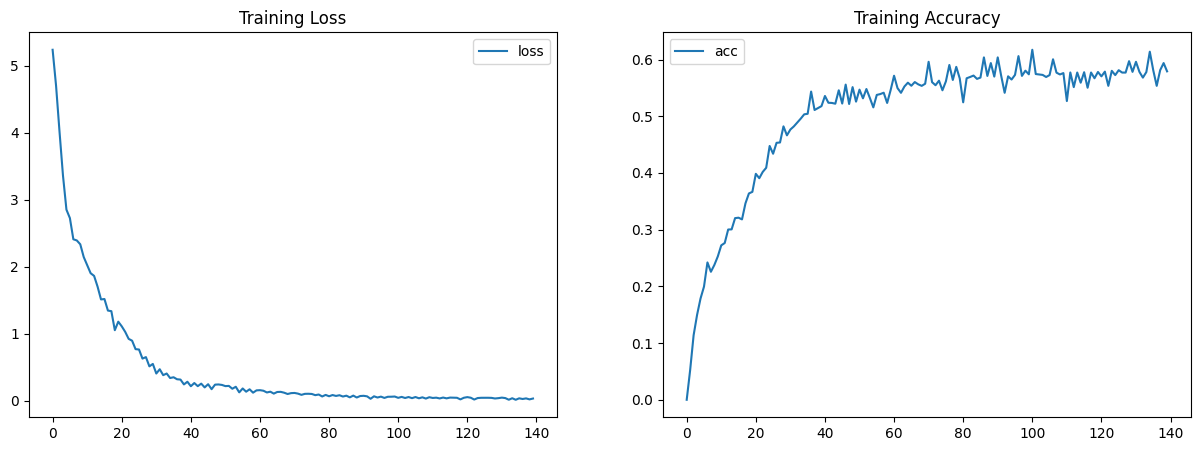

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [34]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
        predictions = transformer(enc_input, output, training=False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [35]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

## BLEU Score Calculation Overview

### What is BLEU?
The **BLEU (Bilingual Evaluation Understudy) score** is a metric used to evaluate the quality of machine-generated translations by comparing them to human-generated reference translations. The higher the BLEU score, the more similar the model’s translations are to human translations.

### Process:

1. **Tokenization**: Input sentences are tokenized and decoded into readable text.
2. **Translation Prediction**: The model generates translations (hypotheses) for the input sentences.
3. **Comparison**: The model’s predictions are compared to human translations (references).
4. **BLEU Calculation**: The BLEU score is computed based on n-gram overlap between the predictions and references, with a brevity penalty to avoid overly short translations being rewarded.

### Final Score:
The BLEU score is printed after processing the entire dataset. A higher score means the translation model is performing well, closely matching human translations.

### Conclusion:
The BLEU score provides an automated way to evaluate machine translation performance by comparing generated sentences to reference translations.

In [36]:
import sacrebleu

def evaluate_bleu_post_training(dataset, transformer, tokenizer_in, tokenizer_out, max_length):
    """Calculate BLEU score on the entire dataset after training."""
    references = []
    hypotheses = []
    
    # Iterate over the entire dataset
    for enc_inputs, targets in dataset:
        # Process each sentence in the batch
        for enc_input, target in zip(enc_inputs.numpy(), targets.numpy()):
            # Decode input and target to text
            input_sentence = tokenizer_in.decode([i for i in enc_input if i < sos_token_input])
            target_sentence = tokenizer_out.decode([i for i in target if i < sos_token_output])
            
            # Predict translation
            predicted_sentence = translate(input_sentence)
            
            # Store reference and hypothesis
            references.append([target_sentence])  # BLEU expects a list of references
            hypotheses.append(predicted_sentence)
    
    # Compute BLEU score
    bleu_score = sacrebleu.corpus_bleu(hypotheses, references).score
    return bleu_score

In [37]:
# Compute BLEU score on the entire dataset after training
print("Computing BLEU score on the entire dataset after training...")
bleu_score = evaluate_bleu_post_training(dataset, transformer, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH)
print(f"Final BLEU score: {bleu_score:.2f}")

Computing BLEU score on the entire dataset after training...
Final BLEU score: 100.00


In [43]:
#Show some translations
sentence = "أنا أحب تعلم اللغات"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: أنا أحب تعلم اللغات
Output sentence: I like studying languages.


In [44]:
#Show some translations
sentence = "أين تقع أقرب محطة قطار؟"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: أين تقع أقرب محطة قطار؟
Output sentence: Where is the closest train station?


In [45]:
#Show some translations
sentence = "هل يمكنك مساعدتي، من فضلك؟"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: هل يمكنك مساعدتي، من فضلك؟
Output sentence: Could you help me?


In [46]:
sentence = "ما اسمك؟"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: ما اسمك؟
Output sentence: What's your name?


In [47]:
sentence = "أنا لا أفهم."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: أنا لا أفهم.
Output sentence: I do not understand.


In [48]:
sentence = "كم الساعة الآن؟"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: كم الساعة الآن؟
Output sentence: What time is it?


In [52]:
sentence = "أنا جائع."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: أنا جائع.
Output sentence: I'm hungry.


In [51]:
sentence = "أريد كوباً من الماء."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: أريد كوباً من الماء.
Output sentence: I want a glass of water.


In [53]:
sentence = "هل تتحدث الإنجليزية؟"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: هل تتحدث الإنجليزية؟
Output sentence: Do you speak English?
